In [3]:
import os
import cv2
import json
import timm
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    f1_score,
    classification_report,
    confusion_matrix,
)

from tqdm import tqdm
from rich import print
from timm.data import ImageDataset
from timm.data.loader import create_loader
from timm.models import create_model, load_checkpoint
from timm.models.vision_transformer import VisionTransformer, _cfg
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

from timm.models.vision_transformer import VisionTransformer, _cfg
from timm.models.registry import register_model
from timm.models.layers import trunc_normal_

from deit.models import *
from deit.models_v2 import *

/home/mohanakrishna/Development/GSSoC/DL-Simplified/Terrain classification/Model/TerrainDeiT3/deit/models.py:62: UserWarning: Overwriting deit_tiny_patch16_224 in registry with deit.models.deit_tiny_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/home/mohanakrishna/Development/GSSoC/DL-Simplified/Terrain classification/Model/TerrainDeiT3/deit/models.py:77: UserWarning: Overwriting deit_small_patch16_224 in registry with deit.models.deit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/home/mohanakrishna/Development/GSSoC/DL-Simplified/Terrain classification/Model/TerrainDeiT3/deit/models.py:92: UserWarning: Overwriting deit_base_patch16_224 in registry with deit.models.deit_base_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is n

### Training Config

In [6]:
# Yaml config file

# Model Config
num_classes = 5
bn_tf = False  # BatchNorm
bn_eps = None  # BatchNorm epsilon override
bn_momentum = None  # BatchNorm momentum Override
checkpoint_path = ""  # Initial checkpoint to start training from
cos_reg = 0
device = "cuda"
drop_rate = 0.0
drop_block = None
drop_connect = None
drop_path_rate = 0.2
global_pool = None
pretrained = False
torchscript = False
use_cos_reg = cos_reg > 0

# training config
auto_augmentation = "rand-m9-mstd0.5-inc1"  # use random augmentation
batch_size = 32
clip_grad = None  # clip the gradients
color_jitter = 0.4
dataset_path = "../../Dataset/Landscape Classification/"
decay_epochs = 30
decay_rate = 0.1
input_size = (
    3,
    224,
    224,
)  # resolve_data_config(vars(args), model=model, verbose=args.local_rank == 0)
min_lr = 1.0e-05
mixup = 0.8
mixup_mode = "batch"
mixup_off_epoch = 0
mixup_prob = 1.0
mixup_switch_prob = 0.5
model_ema = True
model_ema_decay = 0.99996
model_ema_force_cpu = False
momentum = 0.9
no_augmentation = False
num_aug_splits = 0
output = "output/TerrainDeepViT_S"
ratio = [0.75, 1.3333333333333333]  # Random aspect ratio
re_mode = "pixel"  # Random erase
reprob = 0.25
resplit = False
hflip = 0.5  # horizontal flip probability
vflip = 0.0  # vertical flip probability
lr = 0.0005  # Learning rate
lr_cycle_limit = 1
lr_cycle_mul = 1.0
lr_noise = None
lr_noise_pct = 0.67
lr_noise_std = 1.0
optimizer = "adamw"
scheduler = "cosine"
warmup_epochs = 5
warmup_lr = 1.0e-06
weight_decay = 0.05
workers = 8
# use_amp = "apex"

In [11]:
# Download the model
!pwd && wget https://dl.fbaipublicfiles.com/deit/deit_3_small_224_21k.pth

/home/mohanakrishna/Development/GSSoC/DL-Simplified/Terrain classification/Model/TerrainDeiT3
--2024-06-21 19:42:09--  https://dl.fbaipublicfiles.com/deit/deit_3_small_224_21k.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 2600:9000:2576:ba00:13:6e38:acc0:93a1, 2600:9000:2576:c200:13:6e38:acc0:93a1, 2600:9000:2576:4c00:13:6e38:acc0:93a1, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|2600:9000:2576:ba00:13:6e38:acc0:93a1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88296289 (84M) [binary/octet-stream]
Saving to: ‘deit_3_small_224_21k.pth.1’

                dei   1%[                    ]   1.40M  58.0KB/s    eta 13m 50s^C


### Preparing the Data

In [7]:
# Prepare the dataset

root = "../../Dataset/Landscape Classification/"
training_path = root + "train"
validation_path = root + "val"


def read_split_data(root, plot_image=False):
    filepaths_train = []
    labels_train = []

    filepaths_validation = []
    labels_validation = []

    bad_images_train = []
    bad_images_validation = []

    random.seed(0)

    assert os.path.exists(root), "The specified root path doesn't exist"

    classes = [
        c
        for c in os.listdir(training_path)
        if os.path.isdir(os.path.join(training_path, c))
    ]
    classes.sort()

    class_indices = {k: v for v, k in enumerate(classes)}

    print("The created class indices are: \n", class_indices)

    json_str = json.dumps({v: k for k, v in class_indices.items()}, indent=4)

    with open("class_indices.json", "w") as json_file:
        json_file.write(json_str)

    every_class_num = []
    every_class_num_val = []

    supported = [".jpg", ".png", ".jpeg", ".PNG", ".JPG", ".JPEG"]

    print("Training Images:")
    for c in classes:
        # Gather Training Images
        classpath_train = os.path.join(training_path, c)

        if not os.path.exists(classpath_train):
            print(f"{classpath_train} doesn't exist")

        images_train = [
            os.path.join(training_path, c, i)
            for i in os.listdir(classpath_train)
            if os.path.splitext(i)[-1] in supported
        ]

        every_class_num.append(len(images_train))
        file_list_train = sorted(os.listdir(classpath_train))

        desc = f"{c:23}"

        for f in tqdm(
            file_list_train, ncols=110, desc=desc, unit="file", colour="green"
        ):
            fpath = os.path.join(classpath_train, f)
            fl = f.lower()
            index = f.rfind(".")
            ext = f[index:]

            if ext in supported:
                try:
                    cv2.imread(fpath)
                    filepaths_train.append(fpath)
                    labels_train.append(c)
                except:
                    bad_images_train.append(fpath)
                    print("defective image path: ", fpath)
            else:
                bad_images_train.append(fpath)

    validation = [
        v
        for v in os.listdir(validation_path)
        if os.path.isdir(os.path.join(validation_path, v))
    ]
    validation.sort()

    validation_indices = {k: v for v, k in enumerate(validation)}

    print("Validation Images: ")

    for v in validation:
        # Gather Training Images
        classpath_validation = os.path.join(validation_path, v)
        images_validation = [
            os.path.join(validation_path, v, i)
            for i in os.listdir(classpath_validation)
            if os.path.splitext(i)[-1] in supported
        ]

        every_class_num_val.append(len(images_validation))
        file_list_validation = sorted(os.listdir(classpath_validation))

        desc = f"{v:23}"

        for f in tqdm(
            file_list_validation, ncols=110, desc=desc, unit="file", colour="green"
        ):
            fpath = os.path.join(classpath_validation, f)
            fl = f.lower()
            index = f.rfind(".")
            ext = f[index:]

            if ext in supported:
                try:
                    cv2.imread(fpath)
                    filepaths_validation.append(fpath)
                    labels_validation.append(v)
                except:
                    bad_images_validation.append(fpath)
                    print("defective image path: ", fpath)
            else:
                bad_images_validation.append(fpath)

    train_filepath_series = pd.Series(filepaths_train, name="training_filepaths")
    validation_filepath_series = pd.Series(
        filepaths_validation, name="validation_filepaths"
    )

    train_label_series = pd.Series(labels_train, name="labels_train")
    validation_label_series = pd.Series(labels_validation, name="labels_validation")

    df_train = pd.concat([train_filepath_series, train_label_series], axis=1)

    df_validation = pd.concat(
        [validation_filepath_series, validation_label_series], axis=1
    )
    # dump the filepaths and labels for training and validation
    df_train.to_csv("train_dump.csv")
    df_validation.to_csv("validation_dump.csv")

    image_label_train = [class_indices[i] for i in df_train["labels_train"].tolist()]
    image_label_val = [
        class_indices[i] for i in df_validation["labels_validation"].tolist()
    ]

    sample_df = df_train.sample(n=50, replace=False)

    return (
        filepaths_train,
        filepaths_validation,
        image_label_train,
        image_label_val,
        class_indices,
    )


filepath_list_tr, filepath_list_val, label_tr, label_val, cls_indices = read_split_data(
    root=root
)

with open("fpath_tr.txt", "a") as f:
    for i in filepath_list_tr:
        f.write(i)

The created class indices are: 

{'Coast': 0, 'Desert': 1, 'Forest': 2, 'Glacier': 3, 'Mountain': 4}

Training Images:

Mountain               : 100%|████████████████████████████████████████| 2000/2000 [00:00<00:00, 2006.40file/s]


Validation Images:

Mountain               : 100%|██████████████████████████████████████████| 300/300 [00:00<00:00, 1713.41file/s]


In [1]:
!python deit/main.py --model deit_small_patch16_LS --data-path "../../Dataset/Landscape Classification" --batch 128 --lr 2.5e-5 --epochs 30 --weight-decay 0.1 --sched cosine --input-size 224 --eval-crop-ratio 1.0 --reprob 0.0  --smoothing 0.1 --warmup-epochs 5 --drop 0.0 --nb-classes 5 --seed 0 --opt adamw --warmup-lr 1e-6 --mixup .8 --drop-path 0.0 --cutmix 1.0 --unscale-lr --no-repeated-aug --aa rand-m9-mstd0.5-inc1 --finetune ./deit_3_small_224_21k.pth  --output_dir "./output-224-2"

/home/mohanakrishna/Development/GSSoC/DL-Simplified/Terrain classification/Model/TerrainDeiT3/deit/models.py:62: UserWarning: Overwriting deit_tiny_patch16_224 in registry with models.deit_tiny_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/home/mohanakrishna/Development/GSSoC/DL-Simplified/Terrain classification/Model/TerrainDeiT3/deit/models.py:77: UserWarning: Overwriting deit_small_patch16_224 in registry with models.deit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/home/mohanakrishna/Development/GSSoC/DL-Simplified/Terrain classification/Model/TerrainDeiT3/deit/models.py:92: UserWarning: Overwriting deit_base_patch16_224 in registry with models.deit_base_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  

### Evaluation and Inference

torch.Size([1, 196, 384])

torch.Size([1, 196, 384])

there were 197 errors in 1500 tests for an accuracy of  86.87%

The F1-score was 86.928

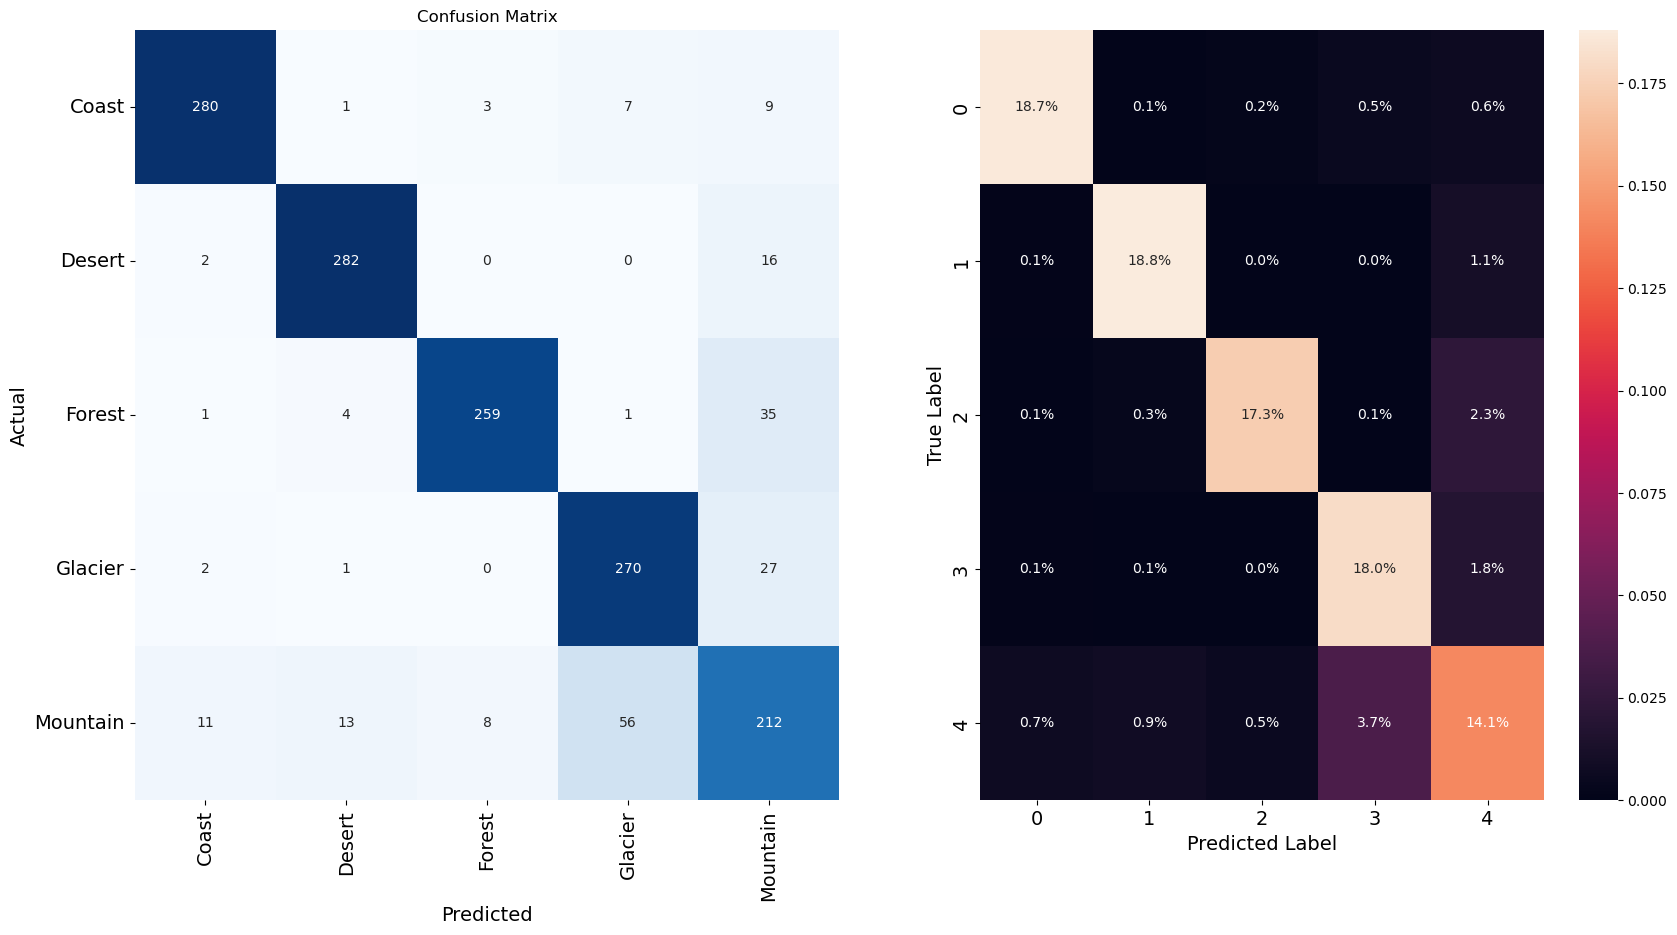

Classification Report:
----------------------
               precision    recall  f1-score   support

       Coast     0.9459    0.9333    0.9396       300
      Desert     0.9369    0.9400    0.9384       300
      Forest     0.9593    0.8633    0.9088       300
     Glacier     0.8084    0.9000    0.8517       300
    Mountain     0.7090    0.7067    0.7078       300

    accuracy                         0.8687      1500
   macro avg     0.8719    0.8687    0.8693      1500
weighted avg     0.8719    0.8687    0.8693      1500

In [9]:
model_path = "./output-224-2/best_checkpoint.pth"
test_data_path = "../../Dataset/Landscape Classification/val"

cfg = {
    "num_classes": 5,
    "input_size": (3, 224, 224),
    "pool_size": None,
    "crop_pct": 0.9,
    "interpolation": "bicubic",
    "fixed_input_size": True,
    "mean": IMAGENET_DEFAULT_MEAN,
    "std": IMAGENET_DEFAULT_STD,
    "first_conv": "patch_embed.proj",
    "classifier": "head",
}

model = create_model(
    "deit_small_patch16_LS",
    pretrained=False,
    num_classes=5,
    drop_path=0.0,
    input_size=(3, 224, 224),
)

loader = create_loader(
    ImageDataset(test_data_path),
    input_size=input_size,
    batch_size=batch_size,
    use_prefetcher=True,
    interpolation="bicubic",
    mean=IMAGENET_DEFAULT_MEAN,
    std=IMAGENET_DEFAULT_STD,
    num_workers=8,
    crop_pct=0.9,
)

# Modifying the positional embedding since this checkpoint is finetuned from a model that initially had 1000 classes
checkpoint = torch.load(model_path, map_location="cpu")
checkpoint_model = checkpoint["model"]

pos_embed_checkpoint = checkpoint_model["pos_embed"]

print(pos_embed_checkpoint.shape)

embedding_size = pos_embed_checkpoint.shape[-1]
num_patches = model.patch_embed.num_patches
num_extra_tokens = model.pos_embed.shape[-2] - num_patches
# height (== width) for the checkpoint position embedding
orig_size = int((pos_embed_checkpoint.shape[-2] - num_extra_tokens) ** 0.5)
# height (== width) for the new position embedding
new_size = int(num_patches**0.5)
# class_token and dist_token are kept unchanged
extra_tokens = pos_embed_checkpoint[:, :num_extra_tokens]
# only the position tokens are interpolated
pos_tokens = pos_embed_checkpoint[:, num_extra_tokens:]
pos_tokens = pos_tokens.reshape(-1, orig_size, orig_size, embedding_size).permute(
    0, 3, 1, 2
)
pos_tokens = torch.nn.functional.interpolate(
    pos_tokens, size=(new_size, new_size), mode="bicubic", align_corners=False
)
pos_tokens = pos_tokens.permute(0, 2, 3, 1).flatten(1, 2)
new_pos_embed = torch.cat((extra_tokens, pos_tokens), dim=1)
checkpoint_model["pos_embed"] = new_pos_embed

print(checkpoint_model["pos_embed"].shape)

model.load_state_dict(checkpoint_model, strict=False)
model.cuda()

try:
    json_file = open("./class_indices.json", "r")
    class_indict = json.load(json_file)
except Exception as e:
    print(e)
    exit(-1)


def predictor(testloader):
    errors = 0
    y_pred, y_true = [], []

    model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # print(f"images:{images.shape}, labels:{labels}, datatype: {images.dtype}")
            images, labels = images.to(device), labels.to(device)
            preds = torch.argmax(model(images), dim=1)
            for i in range(len(preds)):
                y_pred.append(preds[i].cpu())
                y_true.append(labels[i].cpu())

    tests = len(y_pred)
    for i in range(tests):
        pred_index = y_pred[i]
        true_index = y_true[i]
        if pred_index != true_index:
            errors += 1
    acc = (1 - errors / tests) * 100
    print(f"there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%")

    ypred = np.array(y_pred)
    ytrue = np.array(y_true)

    f1score = f1_score(ytrue, ypred, average="weighted") * 100
    print(f"The F1-score was {f1score:.3f}")

    class_count = len(list(class_indict.values()))
    classes = list(class_indict.values())

    cm = confusion_matrix(ytrue, y_pred)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, vmin=0, fmt="g", cmap="Blues", cbar=False)
    plt.xticks(np.arange(class_count) + 0.5, classes, rotation=90, fontsize=14)
    plt.yticks(np.arange(class_count) + 0.5, classes, rotation=0, fontsize=14)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("Actual", fontsize=14)
    plt.title("Confusion Matrix")

    plt.subplot(1, 2, 2)
    sns.heatmap(cm / np.sum(cm), annot=True, fmt=".1%")
    plt.xlabel("Predicted Label", fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("Classification Report:\n----------------------\n", clr)

    return f1score


f1score = predictor(loader)